In [68]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [69]:
ds = xr.open_mfdataset(["data/GFM_global_NASA1km_2018slr_rp0100.nc", "data/GFM_global_NASA1km_2050slr_rp0100.nc"], 
                         combine="nested", concat_dim="time")

# Fix the coordinate lables per file
ds = ds.assign_coords(time=np.array([np.datetime64("2018-01-01"), np.datetime64("2050-01-01")]))


In [80]:
from shapely.geometry import shape

nola_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [-91.730, 29.123],
            [-89.296, 29.123],
            [-89.296, 30.045],
            [-91.730, 30.045],
            [-91.730, 29.123]
          ]
        ]
    }

sfl_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.11181640625, 24.467150664739002],
            [-79.69482421875, 24.467150664739002],
            [-79.69482421875, 26.31311263768267],
            [-82.11181640625, 26.31311263768267],
            [-82.11181640625, 24.467150664739002]
          ]
        ]
      }

sfl_geojson_1 = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.2271728515625,25.854280326572407],
            [-81.1834716796875,25.854280326572407],
            [-81.1834716796875,26.534479888888043],
            [-82.2271728515625,26.534479888888043],
            [-82.2271728515625,25.854280326572407]
          ]
        ]
      }

myanmar_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [92.74658203125,18.542116654448996],
            [94.68017578125,18.542116654448996],
            [94.68017578125,20.406420474920292],
            [92.74658203125,20.406420474920292],
            [92.74658203125,18.542116654448996]
          ]
        ]
      }

png_geojson = {"type":"Polygon","coordinates":[[[137.3291015625,-9.838979375579331],[144.55810546875,-9.838979375579331],[144.55810546875,-4.653079918274038],[137.3291015625,-4.653079918274038],[137.3291015625,-9.838979375579331]]]}

poly = shape(png_geojson)
minx, miny, maxx, maxy = poly.bounds

#### Crop the array to a specified geo-area
- If I wanted a non-bbox polygon, would I have to rasterize a vector and do a mask?

In [81]:
ds = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))

In [82]:
# Check comapre mean inun each year
print(ds.isel(time=0)["inun"].mean().compute())
print(ds.isel(time=1)["inun"].mean().compute())


<xarray.DataArray 'inun' ()>
array(0.8910319, dtype=float32)
Coordinates:
    time     datetime64[ns] 2018-01-01
<xarray.DataArray 'inun' ()>
array(1.1026587, dtype=float32)
Coordinates:
    time     datetime64[ns] 2050-01-01


#### Visualize the coastal inundation

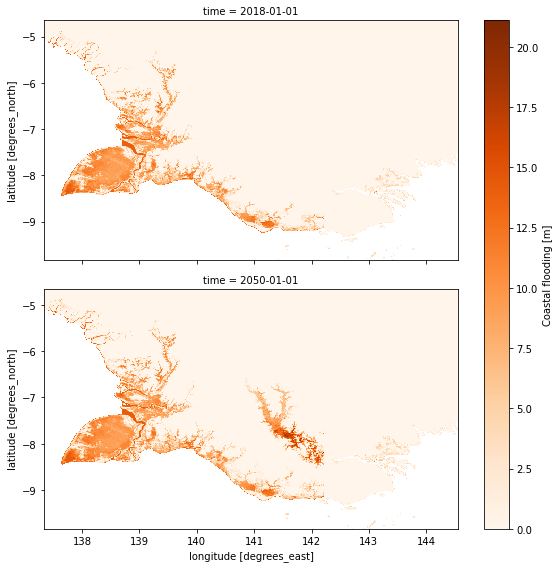

In [83]:
ds.inun.plot(col="time", col_wrap=1, figsize=(8,8), cmap="Oranges")

#### Distribution of inundation amount

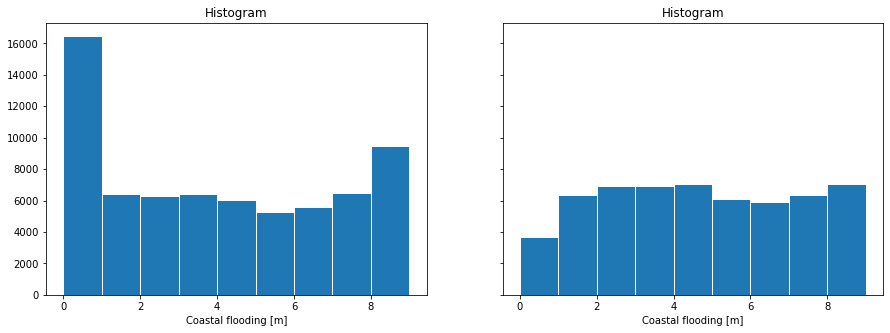

In [84]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True, sharex=True)

# Can't set title?
axes[0].title.set_text("2018 100yr return")
axes[1].set_title("2050 100yr return")

# Faceted plot doesn't seem to work for hist()
for i in range(2):
    ds.inun.isel(time=i).where(ds.inun > 0).plot.hist(ax=axes[i], edgecolor="white", bins=range(0,10))

plt.show()

#### Select only inundated area


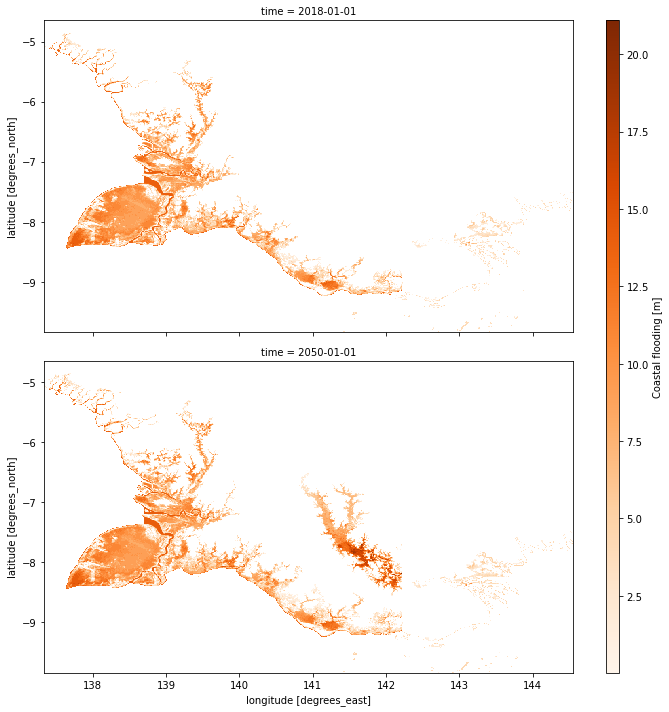

In [85]:
flooded = ds.where(ds.inun > 0)
flooded.inun.plot(col="time", col_wrap=1, figsize=(10, 10), 
                  cmap="Oranges", cbar_kwargs={"aspect": 50})

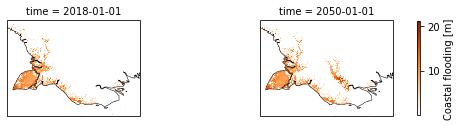

In [86]:
import cartopy.crs as ccrs

prj = ccrs.PlateCarree()

# Too small? https://github.com/pydata/xarray/issues/1397
# https://stackoverflow.com/questions/67265487/xarray-facetgrid-map-with-cartopy-produces-unusable-plot-with-certain-dataset-p
p = flooded.inun.plot(
    col="time",
    col_wrap=None,
    transform=prj,
    subplot_kws={"projection":prj},
    cmap="Oranges",
    cbar_kwargs={"aspect": 30, "shrink": 0.6}
)

for ax in p.axes.flat:
    ax.coastlines(linewidth=0.5)
    ax.set_extent([minx, maxx, miny, maxy])

plt.draw()

#### Plot predicted rise > 1m by 2050

In [87]:
a = ds["inun"].sel(time="2018-01-01")
b = ds["inun"].sel(time="2050-01-01")

diff = (b - a)
diff = diff.where(diff > 1, np.nan)

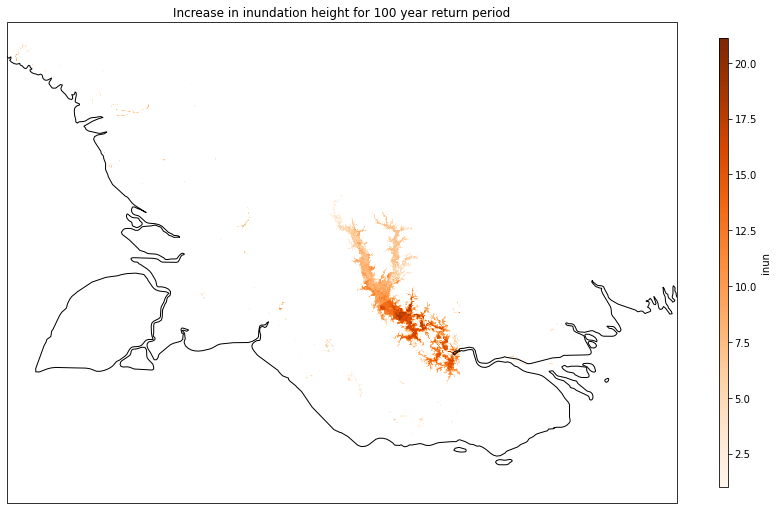

In [88]:
fig, axis = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
    figsize=(15,15)
)

diff.plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    cmap="Oranges",
    cbar_kwargs={"aspect": 50, "shrink": 0.55}
)
plt.title("Increase in inundation height for 100 year return period")
axis.coastlines(color="black", linewidth=1)
axis.set_extent([minx, maxx, miny, maxy])
plt.draw()